In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)

C:\Users\AI-lab\github_repo\neural-network\python\ga.py:197: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9444444444444444, Loss: 0.25732817473234953
Checkpoint 200, Accuracy: 0.9567901234567902, Loss: 0.21874302404898185
Checkpoint 300, Accuracy: 0.9506172839506173, Loss: 0.20213985443115234
Checkpoint 400, Accuracy: 0.9567901234567902, Loss: 0.16814759925559716
Checkpoint 500, Accuracy: 0.9506172839506173, Loss: 0.14503344783076533


In [10]:
print(history)

[{'accuracy': 0.7507788161993769, 'mean_square_error': 2.87856674070184, 'categorical_crossentropy': 0.752271563093239, 'precision': 0.6261682242990654, 'recall': 0.6261682242990654, 'f1': 0.6261682242990654, 'essential_metrics': {0: {'tp_hit': 58, 'fp_hit': 13, 'tn_hit': 22, 'fn_hit': 14}, 1: {'tp_hit': 9, 'fp_hit': 21, 'tn_hit': 67, 'fn_hit': 10}, 2: {'tp_hit': 0, 'fp_hit': 6, 'tn_hit': 85, 'fn_hit': 16}}}, {'accuracy': 0.8504672897196262, 'mean_square_error': 0.3085171041230119, 'categorical_crossentropy': 0.5843931893321955, 'precision': 0.7757009345794392, 'recall': 0.7757009345794392, 'f1': 0.7757009345794392, 'essential_metrics': {0: {'tp_hit': 67, 'fp_hit': 9, 'tn_hit': 26, 'fn_hit': 5}, 1: {'tp_hit': 16, 'fp_hit': 15, 'tn_hit': 73, 'fn_hit': 3}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 16}}}, {'accuracy': 0.881619937694704, 'mean_square_error': 0.2561366157800022, 'categorical_crossentropy': 0.47425061520014966, 'precision': 0.822429906542056, 'recall': 0.82242990

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [12]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [13]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.99502784 0.00227829 0.00269386]
[1. 0. 0.] <-> [0.99148303 0.0040767  0.00444017]
[1. 0. 0.] <-> [0.9899594  0.00773903 0.00230156]
[1. 0. 0.] <-> [0.67627794 0.31684214 0.00687994]
[0. 1. 0.] <-> [1.0171744e-02 9.8937547e-01 4.5275202e-04]
[1. 0. 0.] <-> [0.99691296 0.00185748 0.00122948]
[0. 0. 1.] <-> [0.68151057 0.02097215 0.2975173 ]
[1. 0. 0.] <-> [0.74196947 0.25432098 0.00370955]
[1. 0. 0.] <-> [0.9937589  0.00504764 0.00119344]
[0. 0. 1.] <-> [0.7168821  0.01819929 0.26491866]
[1. 0. 0.] <-> [0.9970552  0.00189747 0.00104733]
[0. 1. 0.] <-> [0.00150728 0.9959585  0.00253426]
[0. 0. 1.] <-> [0.02521751 0.00739207 0.9673904 ]
[0. 0. 1.] <-> [0.02531655 0.00742605 0.96725744]
[0. 0. 1.] <-> [0.01657974 0.00609403 0.9773262 ]
[0. 1. 0.] <-> [1.2385984e-02 9.8723596e-01 3.7802666e-04]
[1. 0. 0.] <-> [0.9846048  0.00436532 0.01102985]
[1. 0. 0.] <-> [0.91201943 0.01396083 0.0740198 ]
[1. 0. 0.] <-> [0.9919836  0.00408486 0.00393156]
[0. 0. 1.] <-> [0.02468543 0.007

In [14]:
# Testing Performance

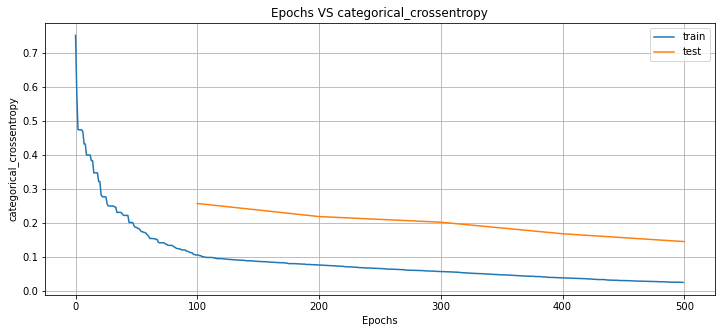

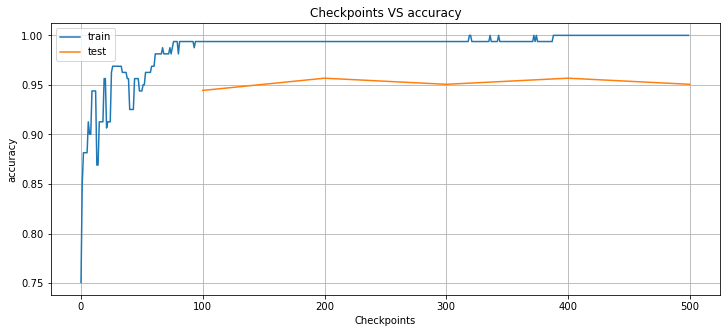

In [15]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [16]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9444444444444444, 'mean_square_error': 0.1297527348635713, 'categorical_crossentropy': 0.25732817473234953, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666, 'essential_metrics': {0: {'tp_hit': 73, 'fp_hit': 4, 'tn_hit': 26, 'fn_hit': 5}, 1: {'tp_hit': 15, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 11, 'fp_hit': 3, 'tn_hit': 91, 'fn_hit': 3}}, 'checkpoint': 100} 


{'accuracy': 0.9567901234567902, 'mean_square_error': 0.10993858530161867, 'categorical_crossentropy': 0.21874302404898185, 'precision': 0.9351851851851852, 'recall': 0.9351851851851852, 'f1': 0.9351851851851852, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 4}, 1: {'tp_hit': 16, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 0}, 2: {'tp_hit': 11, 'fp_hit': 2, 'tn_hit': 92, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.10693706693209037, 'categorical_crossentropy': 0.20213985443115234, 'precis

In [17]:
print(model)

Layer 1
Neuron 0: weights:
[-2.044619    2.9835854   3.          0.03639148 -1.5491638 ]
 bias: -2.810349941253662

Neuron 1: weights:
[-0.608954   2.4071782  0.6836994 -2.1895535 -3.       ]
 bias: 1.6534080505371094

Neuron 2: weights:
[ 1.2054306  3.        -2.7367945 -2.827219  -2.9523172]
 bias: 1.075230598449707

Neuron 3: weights:
[-0.8748683  2.3675818  1.5925153 -2.3973536 -2.6759098]
 bias: -3.0

$
Layer 2
Neuron 0: weights:
[-3.         3.         2.776416  -2.3944678]
 bias: -1.153958797454834

Neuron 1: weights:
[ 2.998813   -0.01322313 -0.27117497  3.        ]
 bias: -2.1157186031341553

Neuron 2: weights:
[-1.6646091  -2.9854832  -3.          0.37727392]
 bias: 2.996889114379883

$

